In [1]:
import pandas as pd
import matplotlib.pyplot as pyplt
%pylab inline
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.linear_model import Ridge, LinearRegression, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
from scipy.stats.stats import pearsonr 

from azureml import Workspace

ws = Workspace()
ds = ws.datasets['county_facts_dictionary.csv']
frame = ds.to_dataframe()

trainDF = ws.datasets['ames_train.csv'].to_dataframe();
testDF = ws.datasets['ames_test.csv'].to_dataframe();
sampleSubmissionDF = ws.datasets['ames_sample_submission.csv'].to_dataframe();

all_data = pd.concat((trainDF.loc[:,'MSSubClass':'SaleCondition'],
                      testDF.loc[:,'MSSubClass':'SaleCondition']))
y = trainDF.SalePrice

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_23/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
trainDF.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
def direct_rmse_error(actual, predicted):
    ans = np.sqrt(np.sum(np.square(actual-predicted))/len(actual))
    return ans

def my_cv(model, x, y, n_splits):
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(X_train)
    ary = []
    for train_index, test_index in kf.split(x):       
        Xtr, Xte = x.ix[train_index, :], x.ix[test_index, :]
        Ytr, Yte = y[train_index], y[test_index]
        model.fit(Xtr, Ytr)
        Y_pred = model.predict(Xte)
        ary.append(direct_rmse_error(Yte, Y_pred))        
    return np.mean(ary)

In [8]:
all_data_temp = all_data.copy()
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
print (all_data.shape)
X_train = all_data[:trainDF.shape[0]] #We are using raw selector operator
X_test = all_data[trainDF.shape[0]:]
y = trainDF.SalePrice
y = log(y)
cv_score = my_cv(LinearRegression(), X_train, y, 5)    
print ("rmse using least square is = ", cv_score)
all_data=all_data_temp

(2919, 288)
rmse using least square is =  0.157122114786


In [9]:
missing = all_data.isnull().sum()
missing.sum()

13965

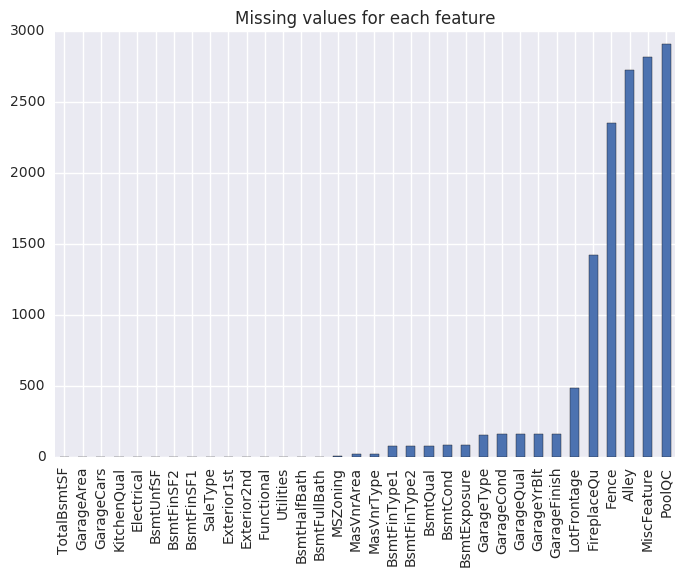

In [10]:
missing = all_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(title='Missing values for each feature')

### PoolQC

In [11]:
all_data.loc[all_data.PoolQC.isnull(), 'PoolQC']='NA'

In [12]:
all_data = all_data.replace({'PoolQC': {'Ex': 4, 
                                            'Gd': 3, 
                                            'TA': 2, 
                                            'Fa': 1,
                                           'NA':0
                                            }
        })

### Alley

In [13]:
all_data.loc[all_data.Alley.isnull(), 'Alley']='NA'

### Fence

In [14]:
all_data.loc[all_data.Fence.isnull(), 'Fence']='NA'

In [15]:
all_data = all_data.replace({'Fence': {'GdPrv': 4, 
                                            'MnPrv': 3, 
                                            'GdWo': 2, 
                                            'MnWw': 1,
                                           'NA':0
                                            }
        })

### FirePlaceQu

In [16]:
all_data.loc[all_data.FireplaceQu.isnull(), 'FireplaceQu']='NA'

In [17]:
all_data = all_data.replace({'FireplaceQu': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                           'NA':0
                                            }        
        })

### Utilities

In [18]:
all_data.loc[all_data.Utilities.isnull(), 'Utilities']='AllPub'

### Kitchen Qualitty

In [19]:
def getCountCategorical(df, column):
    uniqueValues = pd.unique(df[column].values)
    for u in uniqueValues:
        temp=df[column]
        count = temp[df[column]==u].size
        print (u, " = ", count)

In [20]:
getCountCategorical(all_data, 'KitchenQual')

Gd  =  1151
TA  =  1492
Ex  =  205
Fa  =  70
nan  =  0


In [21]:
all_data.loc[all_data.KitchenQual.isnull(), 'KitchenQual']='TA'

In [22]:
all_data = all_data.replace({ 'KitchenQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            }        
        })

### SaleType

In [23]:
all_data.loc[all_data.SaleType.isnull(), 'SaleType']='WD'

### MasVnrArea

In [24]:
all_data.loc[all_data.MasVnrArea.isnull(), 'MasVnrArea']=0

### MasVnrType

In [25]:
all_data.loc[all_data.MasVnrType.isnull(), 'MasVnrType']='None'

### Basement

In [26]:
for c in ['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtHalfBath', 'BsmtFullBath']:
    all_data.loc[all_data[c].isnull(), c]=0

In [27]:
indexes = all_data['BsmtFinType1'].isnull()
for c in ['BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure']:
    all_data.loc[indexes, c]='NA'

In [28]:
indexes = all_data['BsmtFinType1'].isnull()
for c in ['BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure']:
    all_data.loc[indexes, c]='NA'
#We filtered on BsmtFinType1 because it had least no of Nulls. Now there would 2 more Nulls in BsmtCond, need to check it further

In [29]:
getCountCategorical(all_data, 'BsmtCond')

TA  =  2606
Gd  =  122
NA  =  79
Fa  =  104
Po  =  5
nan  =  0


In [30]:
all_data.loc[all_data.BsmtCond.isnull(), 'BsmtCond']='TA'
all_data = all_data.replace({ 'BsmtCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                           'NA':0
                                            }
        })

In [31]:
getCountCategorical(all_data, 'BsmtQual')

Gd  =  1209
TA  =  1283
Ex  =  258
NA  =  79
Fa  =  88
nan  =  0


In [32]:
all_data.loc[all_data.BsmtQual.isnull(), 'BsmtQual']='TA'
all_data = all_data.replace({ 'BsmtQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                           'NA':0
                                            }
        })

In [33]:
getCountCategorical(all_data, 'BsmtExposure')

No  =  1904
Gd  =  276
Mn  =  239
Av  =  418
NA  =  79
nan  =  0


In [34]:
all_data.loc[all_data.BsmtExposure.isnull(), 'BsmtExposure']='No'
all_data = all_data.replace({ 'BsmtExposure': {'Gd': 4, 
                                            'Av': 3, 
                                            'Mn': 2,
                                            'No': 1,
                                              'NA':0
                                            }
        })

In [35]:
getCountCategorical(all_data, 'BsmtFinType2')

Unf  =  2493
BLQ  =  68
NA  =  79
ALQ  =  52
Rec  =  105
LwQ  =  87
GLQ  =  34
nan  =  0


In [36]:
all_data.loc[all_data.BsmtFinType2.isnull(), 'BsmtFinType2']='Unf'
all_data = all_data.replace({ 'BsmtFinType2': {'GLQ': 6, 
                                            'ALQ': 5, 
                                            'BLQ': 4, 
                                            'Rec': 3,
                                            'LwQ': 2,
                                              'Unf':1,
                                              'NA':0
                                            }
        })

### MSZoning

In [37]:
all_data.loc[all_data.MSZoning.isnull(), 'MSZoning']='RL'

### Functional

In [38]:
all_data.loc[all_data.Functional.isnull(), 'Functional']='Typ'
all_data = all_data.replace({ 'Functional': {'Typ': 7, 
                                            'Min1': 6, 
                                            'Min2': 5, 
                                            'Mod': 4,
                                            'Maj1': 3,
                                              'Maj2':2,
                                              'Sev':1,
                                             'Sal':0
                                            }
        })

In [39]:
all_data.loc[all_data.Electrical.isnull(), 'Electrical']='SBrkr'

### LotFrontage

In [40]:
nullIndex = all_data.LotFrontage.isnull()

In [41]:
nonNullIndex = all_data.LotFrontage.notnull()

In [42]:
X_Train = np.sqrt(all_data.LotArea[nonNullIndex])

In [43]:
Y_Train = all_data.LotFrontage[nonNullIndex]

In [44]:
y= np.array(Y_Train)

In [45]:
b=np.array(X_Train)
x = b.reshape(len(b),1)

In [46]:
model = LinearRegression()

In [47]:
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
X_Test = np.sqrt(all_data.LotArea[nullIndex])
b=np.array(X_Test)
xt = b.reshape(len(b),1)
yPred = model.predict(xt)

In [49]:
all_data.loc[nullIndex, 'LotFrontage']=yPred

In [50]:
all_data.LotFrontage.isnull().sum()

0

### Garage

In [51]:
garage = all_data[['GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish', 'GarageType', 'GarageCars', 'GarageArea']]

In [52]:
garage.head()

,GarageCond,GarageQual,GarageYrBlt,GarageFinish,GarageType,GarageCars,GarageArea
0,TA,TA,2003.0,RFn,Attchd,2.0,548.0
1,TA,TA,1976.0,RFn,Attchd,2.0,460.0
2,TA,TA,2001.0,RFn,Attchd,2.0,608.0
3,TA,TA,1998.0,Unf,Detchd,3.0,642.0
4,TA,TA,2000.0,RFn,Attchd,3.0,836.0


In [53]:
garage.GarageYrBlt.isnull().sum()

159

In [54]:
garage[garage.GarageYrBlt.isnull()].head()

,GarageCond,GarageQual,GarageYrBlt,GarageFinish,GarageType,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0
48,NaN,NaN,NaN,NaN,NaN,0.0,0.0
78,NaN,NaN,NaN,NaN,NaN,0.0,0.0
88,NaN,NaN,NaN,NaN,NaN,0.0,0.0
89,NaN,NaN,NaN,NaN,NaN,0.0,0.0


So when garage year blt is null, we can say that there is no garage.
Looking at the data description it seems that GarageType, GarageFinish, GarageQuality, GarageCondition has NA values signifying No Garrage. Replacing them.

In [55]:
all_data.loc[all_data.GarageYrBlt.isnull(), 'GarageCond']='NA'

In [56]:
all_data.loc[all_data.GarageYrBlt.isnull(), 'GarageFinish']='NA'

In [57]:
all_data.loc[all_data.GarageYrBlt.isnull(), 'GarageQual']='NA'

In [58]:
all_data.loc[all_data.GarageYrBlt.isnull(), 'GarageType']='NA'

Now how to impute garage year built, when garage is not built. I think we should check the relation between Garage year build and sale price

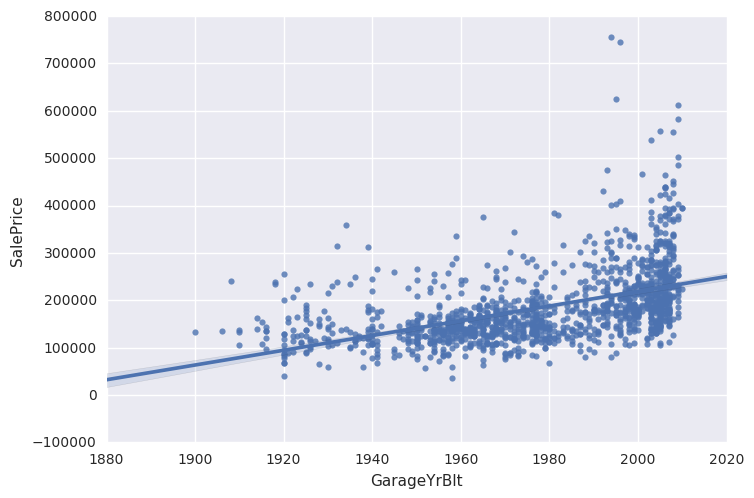

In [59]:
x = trainDF.GarageYrBlt[trainDF.GarageYrBlt.notnull()]
y = trainDF.SalePrice[trainDF.GarageYrBlt.notnull()]
sns.regplot(x, y)

Lets create feature called has garage and draw boxplot

In [60]:
trainDF['HasGarage']=trainDF.GarageYrBlt.apply(lambda x:0 if math.isnan(x) else 1)

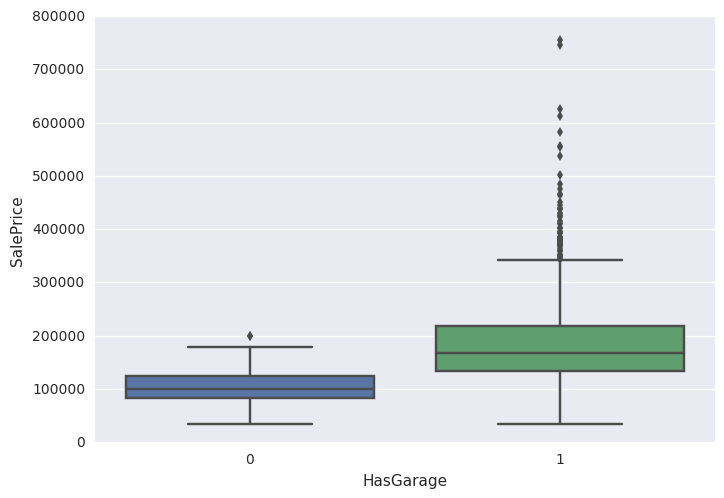

In [61]:
sns.boxplot(x='HasGarage', y='SalePrice', data=trainDF)

Lets make it a zero and introduce a new variable called HasGarage.

In [62]:
all_data.loc[all_data.GarageYrBlt.isnull(), 'GarageYrBlt']=0
all_data['HasGarage']=all_data.GarageYrBlt.apply(lambda x:0 if math.isnan(x) else 1)

We clearly see that house that garage has more price. Now how to impute this value.

In [63]:
garage = all_data[['GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish', 'GarageType', 'GarageCars', 'GarageArea']]

In [64]:
garage[garage.GarageCars.isnull()]

,GarageCond,GarageQual,GarageYrBlt,GarageFinish,GarageType,GarageCars,GarageArea
1116,NA,NA,0.0,NA,NA,NaN,NaN


We will make them zero. We did not do it earlier because there were some cases when garageYrBlt was Null but Garage Cars where not null. Probably they refered to detached garage type. Lets have a look

In [65]:
ind = garage.GarageYrBlt==0

In [66]:
(garage.GarageCars[ind]!=0).sum()

2

In [67]:
(garage.GarageArea[ind]!=0).sum()

2

Okay so these are just two cases, we will make them all zero.

In [68]:
all_data.loc[all_data.GarageCars.isnull(), ('GarageCars', 'GarageArea')]=0

Exterior1st       1
Exterior2nd       1
MiscFeature    2814
dtype: int64

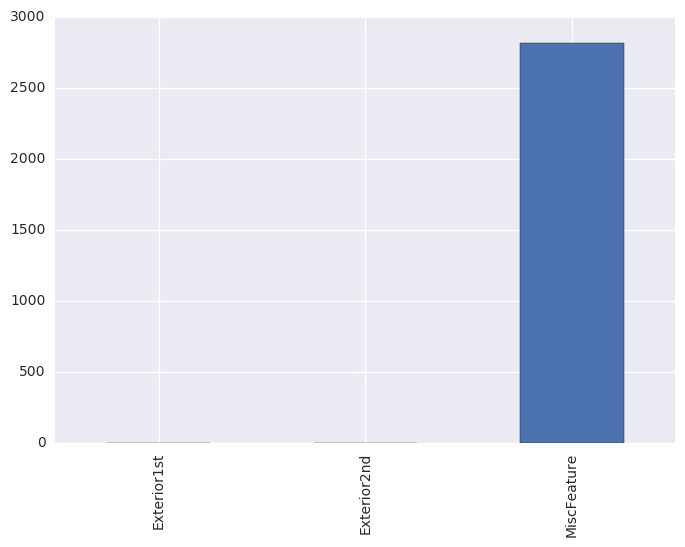

In [69]:
missing = all_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
missing

Cool, these are the feature we had decide to use dummy variables for (along with some other feature). We ared done, lets check performace.

In [70]:
all_data = pd.get_dummies(all_data)
print (all_data.shape)
X_train = all_data[:trainDF.shape[0]] #We are using raw selector operator
X_test = all_data[trainDF.shape[0]:]
y = trainDF.SalePrice
y = log(y)
cv_score = my_cv(LinearRegression(), X_train, y, 5)    
print ("rmse using least square is = ", cv_score)

(2919, 263)
rmse using least square is =  0.155965208656
